# Solving nonogram puzzles in CPMpy
The nonogram puzzle consists of filling in a set of squares.
In this puzzle type, the numbers are a form of discrete tomography that measures how many unbroken lines of filled-in squares there are in any given row or column. [ref: wikipedia]

In [8]:
import urllib
from PIL import Image
import numpy as np

# get picture from web
# for reasonable runtime, limit to size +-200x200 pixels
url = "https://pbs.twimg.com/profile_images/711593363624095747/lJV3XX-H_400x400.jpg"
img = np.array(Image.open(urllib.request.urlopen(url)))

# convert to binary
img = img.mean(axis=2)
thresh = (img.max() - img.min()) / 2
img[img < thresh] = 0
img[img >= thresh] = 1

In [9]:
# convert image to nonogram clues
row_rules = []
for row in img:
    idx = np.concatenate(([0],np.flatnonzero(row[:-1]!=row[1:])+1,[row.size]))
    out = zip(row[idx[:-1]],np.diff(idx))
    row_rules.append([nb for (val, nb) in out if val == 1])

col_rules = []
for col in img.T:
    idx = np.concatenate(([0],np.flatnonzero(col[:-1]!=col[1:])+1,[col.size]))
    out = zip(col[idx[:-1]],np.diff(idx))
    col_rules.append([nb for (val, nb) in out if val == 1])

In [10]:
def transition_function(pattern):
    """
        Pattern is a vector containing the lengths of blocks with value 1
        Returns transition function with format (start_state, char, end_state)
    """
    func = []
    n_states = 0
    for block_length in pattern:
        if block_length == 0:
            continue
        # can stay in same state for emtpy cell
        func += [(n_states, 0, n_states)]
        # group contains exact number of filled cells
        for _ in range(block_length):
            func += [(n_states, 1, n_states+1)]
            n_states += 1
        # go to next subgroup after group is finished
        func += [(n_states, 0, n_states+1)]
        n_states += 1

    func += [(n_states, 0, n_states)]
        # line can end empty or filled
    return func, [n_states-1,n_states]

In [11]:
from cpmpy import *
def nonogram(row_rules, col_rules, **kwargs):

    model = Model()

    n_rows, n_cols = len(row_rules), len(col_rules)
    board = intvar(0,1,shape=(n_rows,n_cols), name="board")

    # add row constraints
    for r, pattern in enumerate(row_rules):
        automaton_func, final_states = transition_function(pattern)
        # OR-tools version of the 'Regular' constraint
        model += NativeConstraint(
            "AddAutomaton",
            [board[r], 0, final_states, automaton_func]
        )

    # add column constraints
    for c, pattern in enumerate(col_rules):
        automaton_func, final_states = transition_function(pattern)
        # OR-tools version of the 'Regular' constraint
        model += NativeConstraint(
            "AddAutomaton",
            [board[:,c], 0, final_states, automaton_func]
        )

    return model, (board,)

In [12]:
model, (board,) = nonogram(row_rules, col_rules)

# Depending on the size of the image, solving may take a long time
assert model.solve(solver="ortools")

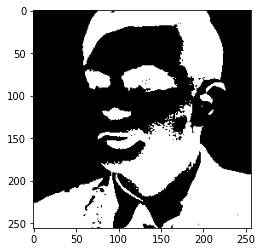

In [13]:
import matplotlib.pyplot as plt
plt.imshow(board.value(),cmap="binary")
plt.show()